In [4]:
# Imports
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

torch.manual_seed(0);

/home/aaron/Pseudos/classes/.conda/envs/classes/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


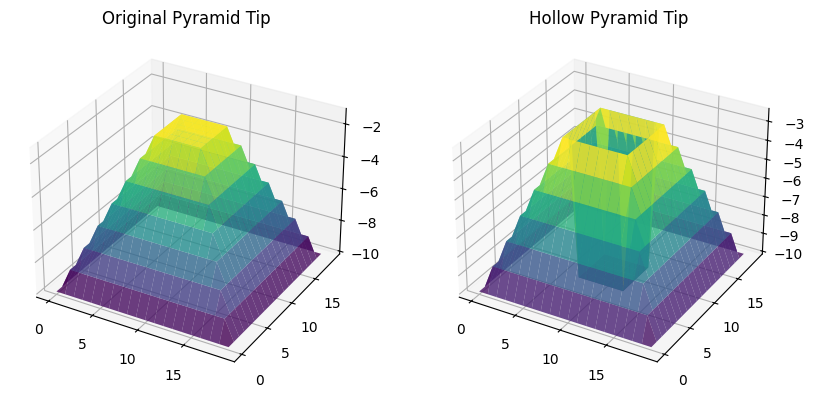

In [5]:
# Assume you have already defined generate_filled_tip function
def generate_filled_tip(size, size_top, height):
    tip = torch.zeros((size, size), dtype=torch.float32)
    x = tip.shape[0]
    y = tip.shape[1]

    for i in range(x // 2 - size_top // 2):
        for j in range(i, x - i):
            for h in range(i, x - i):
                tip[j, h] = i / (x // 2 - size_top // 2) * height
    tip = tip - height

    return tip

def generate_hollow_tip(size, size_top, height):
    tip = generate_filled_tip(size, size_top, height)
    tip_max = torch.max(tip)
    tip[tip == tip_max] = (-height)
    return tip

# Generate pyramid tip and hollow tip
tip_size = 20
tip_size_top = 5
tip_height = 10
pyramid_tip = generate_filled_tip(tip_size, tip_size_top, tip_height)
pyramid_tip_hollow = generate_hollow_tip(tip_size, tip_size_top, tip_height)

# Create a meshgrid
x, y = torch.meshgrid(torch.arange(tip_size), torch.arange(tip_size))

# Plot the original and hollow pyramid tips in 3D
fig = plt.figure(figsize=(10, 5))

# Original Pyramid Tip
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x, y, pyramid_tip, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)
ax.set_title('Original Pyramid Tip')

# Hollow Pyramid Tip
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x, y, pyramid_tip_hollow, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)
ax.set_title('Hollow Pyramid Tip')

plt.show()


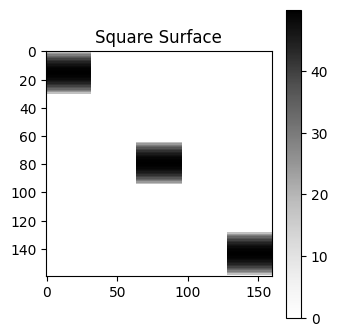

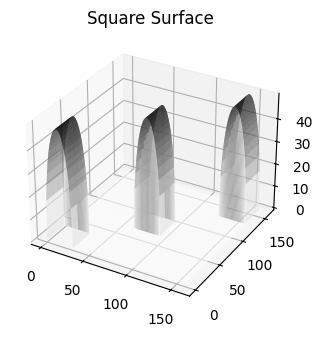

In [13]:
def generate_periodic_square_surface(size, feature_size, height, T):
    surface = torch.zeros((size, size), dtype=torch.float32)

    # for i in range(0, size, T):
    #     for j in range(0, size, T):
    #         surface[:,j:j+feature_size] = height

    for i in range(0, size, T):
        for j in range(0, size, T):
            x = torch.linspace(-1, 1, feature_size)
            y = torch.sqrt(1 - x**2)
            surface[i : i + feature_size, j : j + feature_size] = height * y.view(
                -1, 1
            )

    return surface

# Example: Generate a surface with periodic square features
size = tip_size * 8
feature_size = int(size // 5)
periodicity = int(size // 2.5)
height = 50

periodic_square_surface = generate_periodic_square_surface(size, feature_size, height, periodicity)

# Plot the 2D array as a heatmap
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(periodic_square_surface, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.title('Square Surface')

# Plot the surface in 3D
x, y = torch.meshgrid(torch.arange(size), torch.arange(size))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x, y, periodic_square_surface, cmap='Greys', rstride=1, cstride=1, alpha=0.8, antialiased=True)
ax.set_title('Square Surface')

plt.show()

In [14]:
def idilation(surface, tip):
    surf_xsiz, surf_ysiz = surface.shape
    tip_xsiz, tip_ysiz = tip.shape
    xc = tip_xsiz // 2
    yc = tip_ysiz // 2

    padded_surface = F.pad(surface.unsqueeze(0).unsqueeze(0), (yc, yc, xc, xc), mode='constant', value=0)

    # Create a sliding window view of the padded surface
    window_shape = tip.shape
    strides = padded_surface.stride()[2:] * 2
    windows = torch.as_strided(padded_surface, (surf_xsiz, surf_ysiz) + window_shape, strides)

    # Perform the dilation operation
    dilated = torch.amax(windows + tip.view(1, 1, tip_xsiz, tip_ysiz), dim=(2, 3))

    return dilated.squeeze(0).squeeze(0)

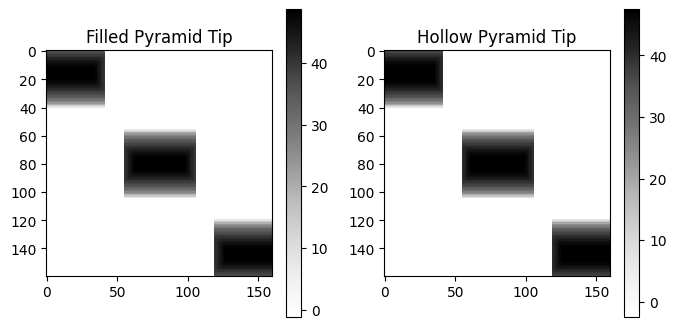

In [15]:
r = idilation(periodic_square_surface, pyramid_tip)
r_hollow = idilation(periodic_square_surface, pyramid_tip_hollow)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(r, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.title('Filled Pyramid Tip')
plt.subplot(1, 2, 2)
plt.imshow(r_hollow, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.title('Hollow Pyramid Tip')
plt.show()

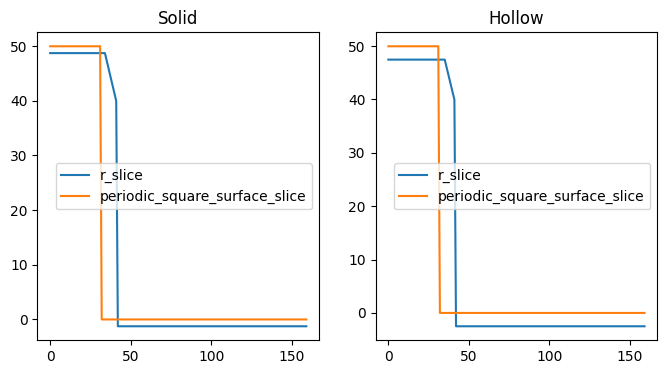

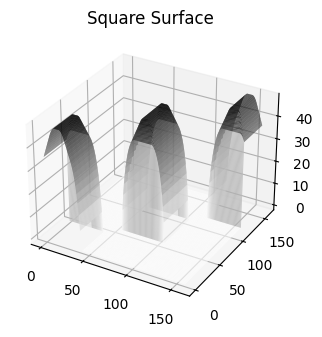

In [19]:
plt.figure(figsize=(8, 4))

r_slice = r[feature_size // 2,:]
periodic_square_surface_slice = periodic_square_surface[feature_size // 2,:]
x1 = range(len(r_slice))
plt.subplot(1, 2, 1)
plt.title("Solid")
plt.plot(x1, r_slice, label='r_slice')
plt.plot(x1, periodic_square_surface_slice, label='periodic_square_surface_slice')
plt.legend()

r_hollow_slice = r_hollow[feature_size // 2,:]
periodic_square_surface_slice = periodic_square_surface[feature_size // 2,:]
x2 = range(len(r_hollow_slice))
plt.subplot(1, 2, 2)
plt.title("Hollow")
plt.plot(x2, r_hollow_slice, label='r_slice')
plt.plot(x2, periodic_square_surface_slice, label='periodic_square_surface_slice')
plt.legend()

# Plot the surface in 3D
x, y = torch.meshgrid(torch.arange(size), torch.arange(size))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x, y, r, cmap='Greys', rstride=1, cstride=1, alpha=0.8, antialiased=True)
ax.set_title('Square Surface')

plt.show()


In [33]:
# Blind-tip reconstruction from Image and Surface

def loss(r_surface, surface, tip, fn):
    return F.mse_loss(r_surface, fn(surface, tip))

def plot_reconstructed_tip(original_tip, reconstructed_tip):
    fig = plt.figure(figsize=(10, 5))
    x, y = torch.meshgrid(torch.arange(tip_size), torch.arange(tip_size))

    # Original Pyramid Tip
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(x, y, original_tip, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)
    ax1.set_title('Original Tip')

    # Hollow Pyramid Tip
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(x, y, reconstructed_tip, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)
    ax2.set_title('Reconstructed Tip')

    plt.show()

def optimize(surface, original_tip, tip, epochs, fn, lr, min_loss=1e-3):
    r_surface = fn(surface, original_tip)

    losses = []
    optimizer = optim.Adam([tip], lr=lr)

    t = tqdm(range(epochs))
    for epoch in t:
        optimizer.zero_grad()

        loss_val = loss(r_surface, surface, tip, fn)
        loss_val.backward()

        optimizer.step()

        description = f'Epoch: {epoch}, Loss: {loss_val.item():.4f}'
        t.set_description(description)
        if epoch % (epochs // 10) == 0:
            with torch.no_grad():
                print(description)
                # plot_reconstructed_tip(original_tip, tip)

        losses.append(loss_val.item())

        # Early stopping
        # 1. If loss is less than min_loss
        # 2. If loss hasn't decreased over the last 10 epochs
        if loss_val.item() < min_loss:
            print('Loss is less than min_loss')
            break
        elif epoch > 10 and losses[-1] >= losses[-10]:
            print('Loss has not decreased over the last 10 epochs')
            break

    return tip, losses

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0, Loss: 14.3779
Epoch: 100, Loss: 5.4242
Epoch: 200, Loss: 2.5937
Epoch: 300, Loss: 1.2447
Epoch: 400, Loss: 0.5630
Epoch: 500, Loss: 0.2389
Epoch: 600, Loss: 0.0955
Epoch: 700, Loss: 0.0363
Epoch: 800, Loss: 0.0128
Epoch: 900, Loss: 0.0041


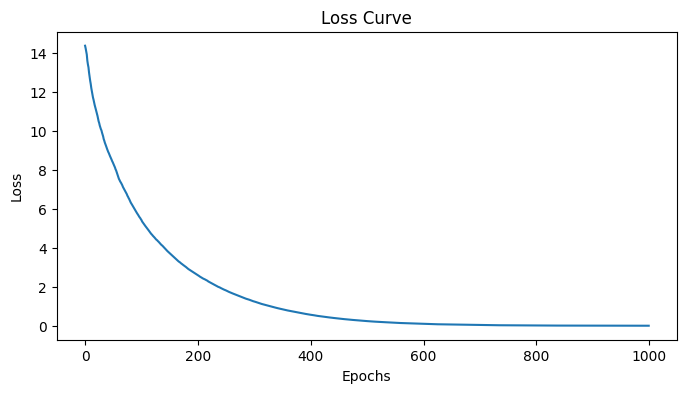

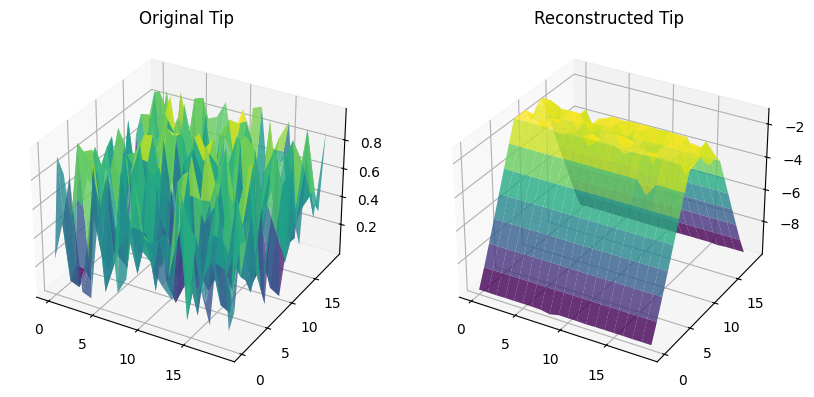

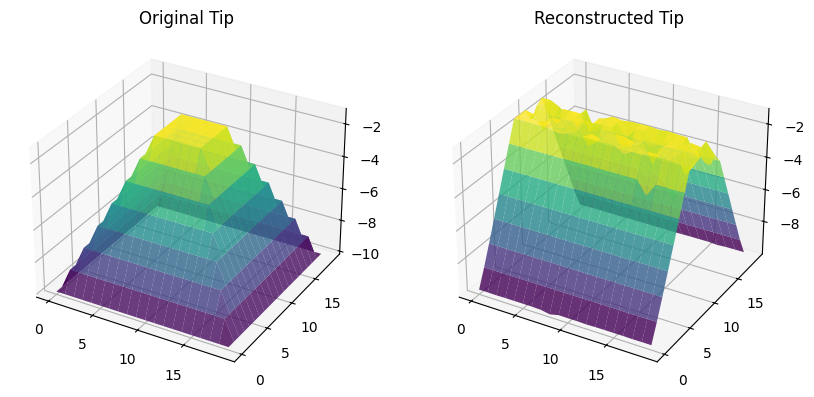

In [21]:
# Run the optimization
epochs = 1000
lr = 0.1
random_tip = torch.rand((tip_size, tip_size), requires_grad=True)
original_random_tip = random_tip.clone().detach()
reconstructed_tip, losses = optimize(periodic_square_surface, pyramid_tip, random_tip, epochs, idilation, lr)

# Plot the loss curve
plt.figure(figsize=(8, 4))
plt.plot(range(epochs), losses)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot the reconstructed tip
plot_reconstructed_tip(original_random_tip, reconstructed_tip.detach())
plot_reconstructed_tip(pyramid_tip, reconstructed_tip.detach())

In [25]:
def ierosion(surface, tip):
    surf_xsiz, surf_ysiz = surface.shape
    tip_xsiz, tip_ysiz = tip.shape
    xc = tip_xsiz // 2
    yc = tip_ysiz // 2

    padded_surface = F.pad(surface.unsqueeze(0).unsqueeze(0), (yc, yc, xc, xc), mode='constant', value=0)

    # Create a sliding window view of the padded surface
    window_shape = tip.shape
    strides = padded_surface.stride()[2:] * 2
    windows = torch.as_strided(padded_surface, (surf_xsiz, surf_ysiz) + window_shape, strides)

    # Perform the erosion operation
    eroded = torch.amin(windows - tip.view(1, 1, tip_xsiz, tip_ysiz), dim=(2, 3))

    return eroded.squeeze(0).squeeze(0)

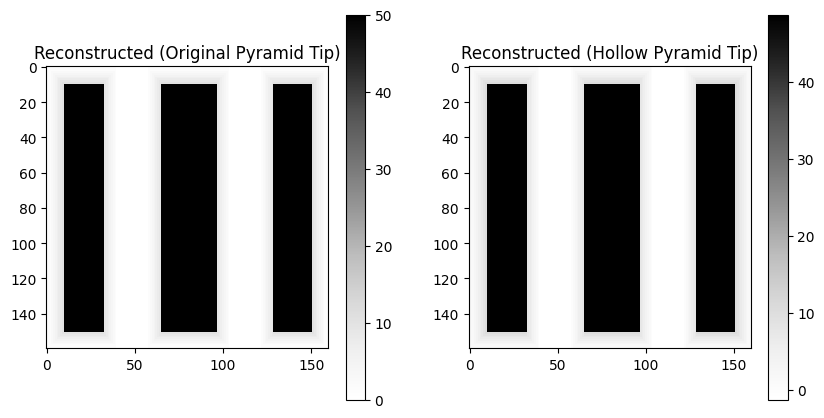

In [26]:
reconstructed_surface = ierosion(r, pyramid_tip)
reconstructed_surface_hollow = ierosion(r_hollow, pyramid_tip_hollow)

# Plot the pyramid_tip_filled
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(reconstructed_surface, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.title('Reconstructed (Original Pyramid Tip)')

# Plot the pyramid_tip_hollow
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_surface_hollow, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.title('Reconstructed (Hollow Pyramid Tip)')

plt.show()

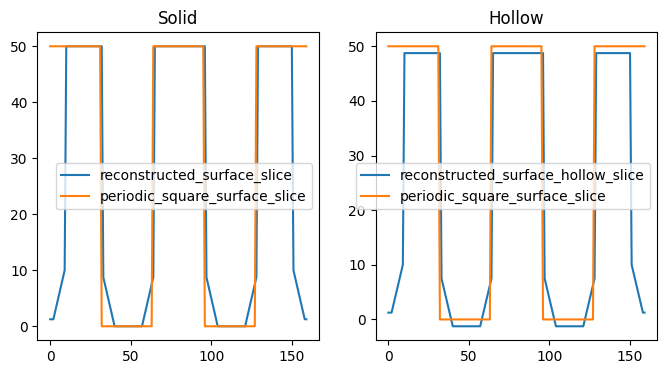

In [24]:
plt.figure(figsize=(8, 4))

reconstructed_surface_slice = reconstructed_surface[feature_size,:]
periodic_square_surface_slice = periodic_square_surface[feature_size,:]
x1 = range(len(reconstructed_surface_slice))
plt.subplot(1, 2, 1)
plt.title("Solid")
plt.plot(x1, reconstructed_surface_slice, label='reconstructed_surface_slice')
plt.plot(x1, periodic_square_surface_slice, label='periodic_square_surface_slice')
plt.legend()

reconstructed_surface_hollow_slice = reconstructed_surface_hollow[feature_size,:]
periodic_square_surface_slice = periodic_square_surface[feature_size,:]
x2 = range(len(reconstructed_surface_hollow_slice))
plt.subplot(1, 2, 2)
plt.title("Hollow")
plt.plot(x2, reconstructed_surface_hollow_slice, label='reconstructed_surface_hollow_slice')
plt.plot(x2, periodic_square_surface_slice, label='periodic_square_surface_slice')
plt.legend()

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0, Loss: 19.3169
Epoch: 100, Loss: 8.9381
Epoch: 200, Loss: 4.8293
Epoch: 300, Loss: 2.5133
Epoch: 400, Loss: 1.2340
Epoch: 500, Loss: 0.5810
Epoch: 600, Loss: 0.2599
Epoch: 700, Loss: 0.1126
Epoch: 800, Loss: 0.0490
Epoch: 900, Loss: 0.0219


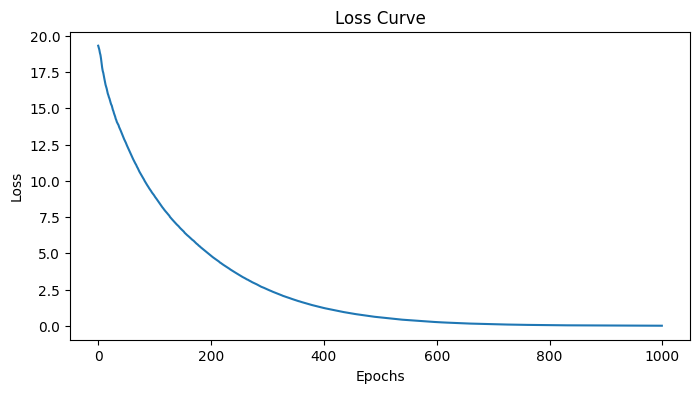

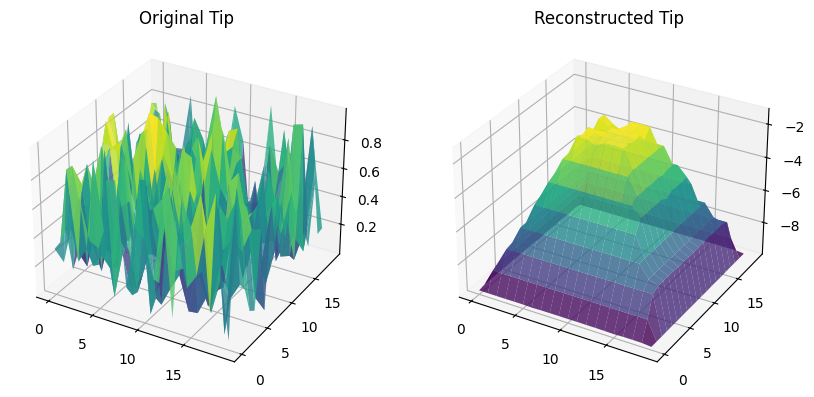

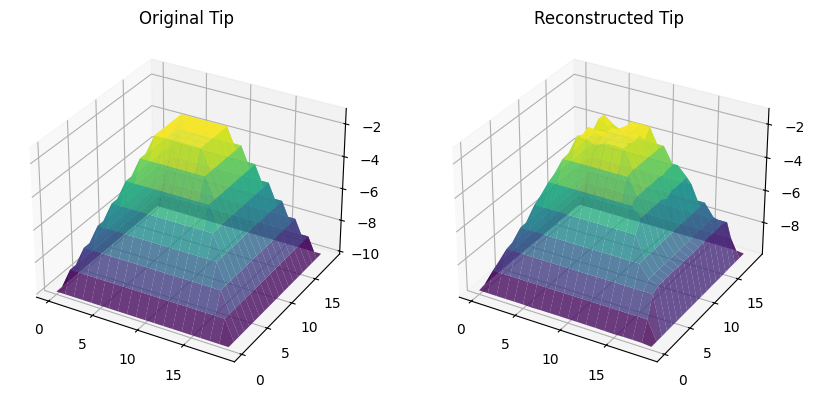

In [32]:
# Run the optimization
epochs = 1000
lr = 0.1
random_tip = torch.rand((tip_size, tip_size), requires_grad=True)
original_random_tip = random_tip.clone().detach()
reconstructed_tip, losses = optimize(periodic_square_surface, pyramid_tip, random_tip, epochs, ierosion, lr)

# Plot the loss curve
plt.figure(figsize=(8, 4))
plt.plot(range(epochs), losses)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot the reconstructed tip
plot_reconstructed_tip(original_random_tip, reconstructed_tip.detach())
plot_reconstructed_tip(pyramid_tip, reconstructed_tip.detach())

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0, Loss: 12.8335
Epoch: 50, Loss: 8.5508
Epoch: 100, Loss: 6.0841
Epoch: 150, Loss: 4.4411
Epoch: 200, Loss: 3.2786
Epoch: 250, Loss: 2.4180
Epoch: 300, Loss: 1.6929
Epoch: 350, Loss: 1.2170
Epoch: 400, Loss: 0.8594
Epoch: 450, Loss: 0.6004


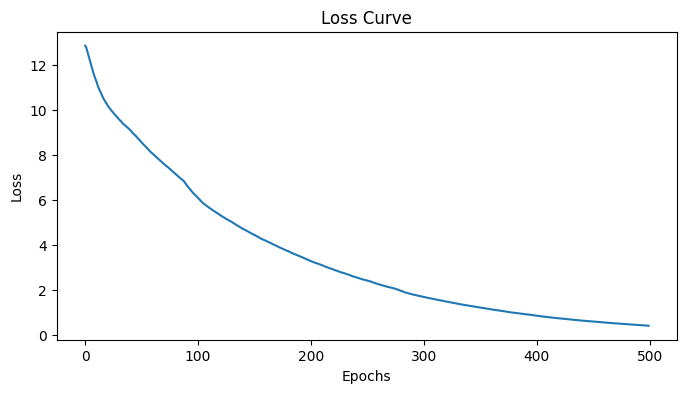

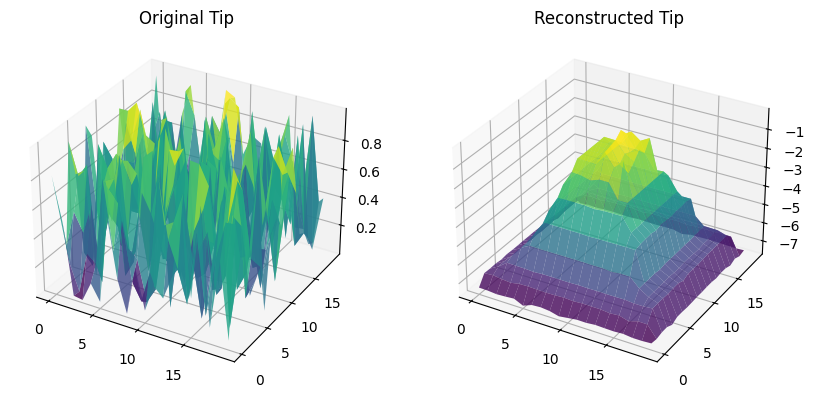

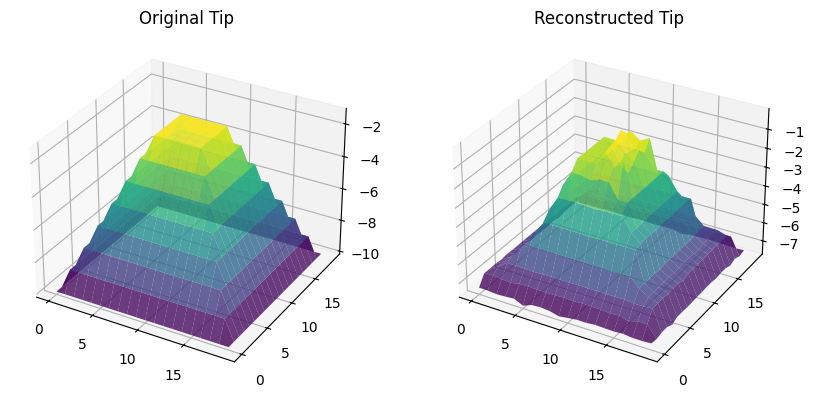

In [36]:
# Run the optimization
epochs = 500
lr = 0.1
random_tip = torch.rand((tip_size, tip_size), requires_grad=True)
original_random_tip = random_tip.clone().detach()
idilation_and_ierosion = lambda surface, tip: ierosion(idilation(surface, tip), tip)
reconstructed_tip, losses = optimize(periodic_square_surface, pyramid_tip, random_tip, epochs, idilation_and_ierosion, lr)

# Plot the loss curve
plt.figure(figsize=(8, 4))
plt.plot(range(epochs), losses)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot the reconstructed tip
plot_reconstructed_tip(original_random_tip, reconstructed_tip.detach())
plot_reconstructed_tip(pyramid_tip, reconstructed_tip.detach())